In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# SEIR model

In [2]:
from covid19be import load_data
data = load_data()

In [3]:
hyper_parameters = {
    "frac_dh": 2985 / 6490,  # deaths in hospitals / total deaths
    "hh": 0.05,              # fraction of hospitalized 
    "gamma": 1 / 12.4,       # inverse recovery time"
    "epsilon": 1 / 5.2,      # inverse incubation time 
    "dea": 0.5,              # fatality rate in icu 
    "n0": 11000000,          # population size
    "n0_MRS": 400000,        # population en MR/MRS + personnel soignant
    "window": 6,             # size of the window for fitting Re's"
}

def smoothen(v, n_pts=hyper_parameters["window"]):
    box = np.ones(n_pts) / n_pts
    return np.convolve(v, box, mode="same")

def SEIR(r0, i0=3, gg=0.75, n_futures=0, opts=hyper_parameters):   
    # Load hyper-parameters
    hh = opts["hh"]
    gamma = opts["gamma"]
    epsilon = opts["epsilon"]
    dea = opts["dea"]
    n0 = opts["n0"]
    n0_MRS = opts["n0_MRS"]
    window = opts["window"]
    
    # Smoothen and extend R0s
    r0 = smoothen(r0)
    r0 = np.concatenate((r0, np.array([r0[-1]] * (window + n_futures))))
    
    # Initial conditions
    drea = dea * 1 / 5
    rrea = (1 - dea) * 1 / 20
    hospi = 0.0
    
    n = [n0-n0_MRS]
    i = [i0]
    e = [i[-1] * 37]
    h = [0.0]
    l = [0.0]
    r = [0.0]
    m = [0.0]
    s = [n[-1] - e[-1] - i[-1] - r[-1]]
    
    # Simulate forward
    n_days = len(r0)
    
    for day in range(n_days):
        lam = gamma * r0[day]
        
        if day == 14:
            hospi = hh / 7
            
        ds = -lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1]
        de = lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1] - epsilon * e[-1]
        di = epsilon * e[-1] - gamma * i[-1] - hospi * i[-1]
        dh = hospi * i[-1] - gg * h[-1] / 7 - (1 - gg) * h[-1] / (4 + 2 * np.tanh((l[-1]-500)/300))
        dl = (1 - gg) * h[-1] / (4 + 2 * np.tanh((l[-1]-500)/300)) - drea * l[-1] - rrea * l[-1]
        dr = gamma * i[-1] + rrea * l[-1] + gg * h[-1] / 7
        dm = drea * l[-1] 
        
        s.append(s[-1] + ds)
        e.append(e[-1] + de)
        i.append(i[-1] + di)
        h.append(h[-1] + dh)
        l.append(l[-1] + dl)
        if l[-1] > 1895:
            dm = dm + (l[-1] - 1895)
            l[-1] = 1895
        r.append(r[-1] + dr)
        m.append(m[-1] + dm)
        n.append(s[-1] + e[-1] + i[-1] + h[-1] + l[-1] + r[-1])
        
    return np.array(s), np.array(e), np.array(i), np.array(h), np.array(l), np.array(m), np.array(r)

def SEIR_MRS(r0_mrs, n_futures=0, opts=hyper_parameters):
    # Load hyper-parameters
    gamma = opts["gamma"]
    epsilon = opts["epsilon"]
    n0_MRS = opts["n0_MRS"]
    window = opts["window"]
    
    # Smoothen and extend R0s
    r0_mrs = smoothen(r0_mrs)
    r0_mrs = np.concatenate((r0_mrs, np.array([r0_mrs[-1]] * (window + n_futures))))
    
    # Initial conditions
    alpha = 0.15 / 10
    lam = gamma * 4.3
    
    n = [n0_MRS]
    i = [1]
    e = [i[-1]*20]
    r = [0.0]
    s = [n[-1] - e[-1] - i[-1] - r[-1]]
    m = [0.0]
    
    # Simulate forward
    n_days = len(r0_mrs)
    
    for day in range(n_days):
        lam = gamma * r0_mrs[day]
        
        ds = -lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1]
        de = lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1] - epsilon * e[-1]
        di = epsilon * e[-1] - (gamma + alpha) * i[-1]
        dr = gamma * i[-1]
        dm = alpha * i[-1]
        
        s.append(s[-1] + ds)
        e.append(e[-1] + de)
        i.append(i[-1] + di)
        r.append(r[-1] + dr)
        m.append(m[-1] + dm)
        n.append(s[-1] + e[-1] + i[-1] + r[-1])
        
    return np.array(s), np.array(e), np.array(i), np.array(m), np.array(r)   

def simulate(theta, n_futures=0):   
    # Unpack parameters
    r0, r0_mrs, i0, gg = theta
    
    # Simulate
    s, e, i, h, l, m, r = SEIR(r0, i0=i0, gg=gg, n_futures=n_futures)
    _, _, _, m_mrs, _ = SEIR_MRS(r0_mrs, n_futures=n_futures)
    
    return s, e, i, h, l, m, m_mrs, r

In [4]:
# Log-likelihood functions and samplers
from scipy.stats import norm, poisson
from scipy.special import gammaln

def normal_logpdf(x, mu, sigma=1):
    return norm.logpdf(x, loc=mu, scale=sigma).sum()

def normal_rvs(mu, sigma=1, random_state=None):
    return norm.rvs(loc=mu, scale=sigma, random_state=random_state)

def sqrt_normal_logpdf(x, mu, sigma=1):
    return norm.logpdf(x ** 0.5, loc=mu ** 0.5, scale=sigma).sum()

def sqrt_normal_rvs(mu, sigma=1, random_state=None):
    return norm.rvs(loc=mu ** 0.5, scale=sigma, random_state=random_state) ** 2

def poisson_logpdf(x, mu, sigma=None):
    #return poisson.logpmf(x, mu).sum()
    return (x * np.log(mu.astype(float) + 1e-10) - mu - gammaln(x.astype(float) + 1e-10)).sum()

def poisson_rvs(mu, sigma=None, random_state=None):
    return poisson.rvs(mu, random_state=random_state)

# Parameter fit

In [5]:
from scipy.optimize import minimize

# Pack-unpack helpers for passing parameters around
def pack(r0, r0_rms, i0, gg):
    v = np.zeros(len(r0) + len(r0_rms) + 2)
    v[:len(r0)] = r0
    v[len(r0):len(r0)+len(r0_rms)] = r0_rms
    v[-2] = i0
    v[-1] = gg
    return v 

def unpack(v):
    return v[:(len(v)-2)//2], v[(len(v)-2)//2:len(v)-2], v[-2], v[-1]

# Fit
def fit(data, logpdf=poisson_logpdf, opts=hyper_parameters):
    # Load hyper-parameters
    window = opts["window"]
    frac_dh = opts["frac_dh"]
    
    # Cost
    def cost(x):
        # parameters
        r0, r0_mrs, i0, gg = unpack(x)

        # cost
        c = 0.0

        s, e, i, h, l, m, r = SEIR(r0, i0=i0, gg=gg)
        c -= logpdf(data["n_hospitalized"].values[9:], mu=h[10:]+l[10:])
        c -= logpdf(data["n_icu"].values[9:], mu=l[10:])
        c -= logpdf(frac_dh * data["n_deaths"].values[9:-2], mu=m[10:-2])

        # fit on deaths with SEIR_MRS
        s, e, i, m_mrs, r = SEIR_MRS(r0_mrs)
        c -= logpdf(data["n_deaths"].values[:-2], mu=m[1:-2] + m_mrs[1:-2])

        # ^ we omit the last two death data points, because not consolidated yet

        return c
 
    # x0
    r0 = [4.3] * (len(data) - window)
    r0_rms = [4.3] * (len(data) - window)
    i0 = 3.0
    gg = 0.75
    x0 = pack(r0, r0_rms, i0, gg)

    # bounds
    bounds = []
    for _ in range(len(r0)):
        bounds.append((0.25, 5.0))
    for _ in range(len(r0_rms)):
        bounds.append((0.25, 10.0))
    bounds.append((1, 50))
    bounds.append((0.65, 0.85))

    # fit
    res = minimize(cost, x0=x0, bounds=bounds, options={"maxfun": 25000})
    
    return unpack(res.x)

# Parametric bootstrap

In [6]:
from copy import deepcopy
from joblib import Parallel, delayed

def _fit(data, h, l, m, m_mrs, seed, logpdf=poisson_logpdf, rvs=poisson_rvs):
    data_i = deepcopy(data)
    rs = np.random.RandomState(seed=seed)
    
    # resample
    data_i["n_hospitalized"] = rvs(h[1:] + l[1:], random_state=rs)
    data_i["n_icu"] = rvs(l[1:], random_state=rs)
    data_i["n_deaths"] = rvs(m[1:] + m_mrs[1:], random_state=rs)
    
    # fit on bootstrap
    theta_i = fit(data_i, logpdf=logpdf)
    
    return theta_i

def parametric_bootstrap(data, n_replicas=1, logpdf=poisson_logpdf, n_jobs=-1):
    # Best fit on original data
    theta_mle = fit(data, logpdf=logpdf)
    _, _, _, h, l, m, m_mrs, _ = simulate(theta_mle)
    
    # Bootstrap    
    thetas_bootstrap = Parallel(n_jobs=n_jobs, verbose=10, backend="multiprocessing")(
        delayed(_fit)(data, h, l, m, m_mrs, i) for i in range(n_replicas))
        
    return theta_mle, thetas_bootstrap

In [7]:
# this will take a while...
theta_mle, thetas_bootstrap = parametric_bootstrap(data, n_replicas=100, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 17.6min remaining:   44.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 18.1min finished


In [8]:
# Plots
n_futures = 365
n_days = len(data)
window = hyper_parameters["window"]

bootstraps = {
    "h": [],
    "l": [],
    "m": [],
    "m_mrs": [],
    "r0": [],
    "r0_mrs": []
}

for theta_i in thetas_bootstrap:
    _, _, _, h, l, m, m_mrs, _ = simulate(theta_i, n_futures=n_futures)
    bootstraps["h"].append(h)
    bootstraps["l"].append(l)
    bootstraps["m"].append(m)
    bootstraps["m_mrs"].append(m_mrs)
    
    r0, r0_mrs, _, _ = theta_i    
    _r0 = smoothen(r0)
    _r0_mrs = smoothen(r0_mrs)
    _r0 = np.concatenate((_r0, np.array([_r0[-1]] * (window + n_futures))))
    _r0_mrs = np.concatenate((_r0_mrs, np.array([_r0_mrs[-1]] * (window + n_futures))))
    
    bootstraps["r0"].append(_r0)
    bootstraps["r0_mrs"].append(_r0_mrs)
    
for k, v in bootstraps.items():
    bootstraps[k] = np.array(v)

In [9]:
hl_50 = np.percentile(bootstraps["h"]+bootstraps["l"], 50, axis=0)
hl_10 = np.percentile(bootstraps["h"]+bootstraps["l"], 10, axis=0)
hl_90 = np.percentile(bootstraps["h"]+bootstraps["l"], 90, axis=0)

l_50 = np.percentile(bootstraps["l"], 50, axis=0)
l_10 = np.percentile(bootstraps["l"], 10, axis=0)
l_90 = np.percentile(bootstraps["l"], 90, axis=0)

m_50 = np.percentile(bootstraps["m"]+bootstraps["m_mrs"], 50, axis=0)
m_10 = np.percentile(bootstraps["m"]+bootstraps["m_mrs"], 10, axis=0)
m_90 = np.percentile(bootstraps["m"]+bootstraps["m_mrs"], 90, axis=0)

r0_50 = np.percentile(bootstraps["r0"], 50, axis=0)
r0_10 = np.percentile(bootstraps["r0"], 10, axis=0)
r0_90 = np.percentile(bootstraps["r0"], 90, axis=0)

r0_mrs_50 = np.percentile(bootstraps["r0_mrs"], 50, axis=0)
r0_mrs_10 = np.percentile(bootstraps["r0_mrs"], 10, axis=0)
r0_mrs_90 = np.percentile(bootstraps["r0_mrs"], 90, axis=0)

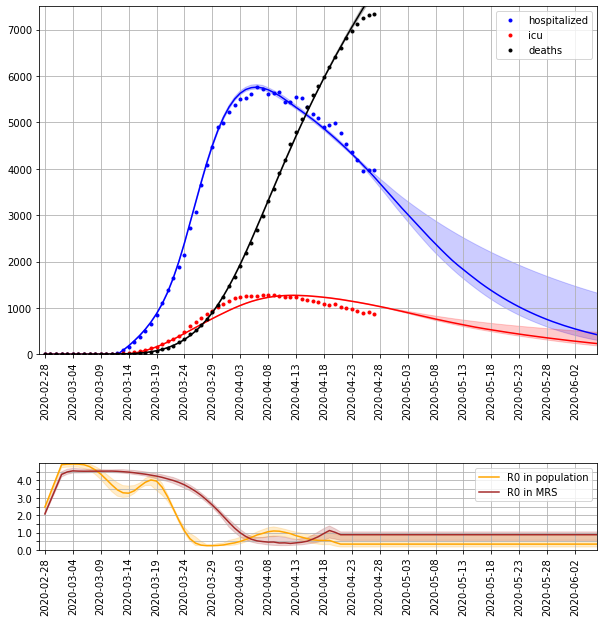

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={"height_ratios": (4, 1)})

# Plot hospitalizations, icus and deaths
ax[0].plot(range(1, n_days+1 + n_futures), hl_50[1:], c="b")
ax[0].fill_between(range(1, n_days+1 + n_futures), hl_10[1:], hl_90[1:], color="b", alpha=0.2)
ax[0].plot(range(1, n_days+1), data["n_hospitalized"].values, ".", c="b", label="hospitalized")

ax[0].plot(range(1, n_days+1 + n_futures), l_50[1:], c="r")
ax[0].fill_between(range(1, n_days+1 + n_futures), l_10[1:], l_90[1:], color="r", alpha=0.2)
ax[0].plot(range(1, n_days+1), data["n_icu"].values, ".", c="r", label="icu")

ax[0].plot(range(1, n_days+1 + n_futures), m_50[1:], c="k")
ax[0].fill_between(range(1, n_days+1 + n_futures), m_10[1:], m_90[1:], color="k", alpha=0.2)
ax[0].plot(range(1, n_days+1), data["n_deaths"].values, ".", c="k", label="deaths")

ax[0].grid()
ax[0].set_ylim(0, 7500)
ax[0].set_xlim(0, 100)
ax[0].set_xticks(np.arange(1, 100, 5))
ax[0].set_xticklabels([d.strftime('%Y-%m-%d') for d in pd.date_range(start="2020-02-28", end="2020-12-31")[:100:5]], rotation=90)
ax[0].legend()

# Plots R0s
ax[1].plot(range(1, n_days+1 + n_futures), r0_50, c="orange", label="R0 in population")
ax[1].fill_between(range(1, n_days+1 + n_futures), r0_10, r0_90, color="orange", alpha=0.2)

ax[1].plot(range(1, n_days+1 + n_futures), r0_mrs_50, c="brown", label="R0 in MRS")
ax[1].fill_between(range(1, n_days+1 + n_futures), r0_mrs_10, r0_mrs_90, color="brown", alpha=0.2)

ax[1].grid(which="both")
ax[1].set_ylim(0, 5)
ax[1].set_yticks(np.arange(0, 5, step=0.5))
for j, label in enumerate(ax[1].get_yticklabels()):
    if j % 2 != 0:
        label.set_visible(False)
ax[1].set_xlim(0, 100)
ax[1].set_xticks(np.arange(1, 100, 5))
ax[1].set_xticklabels([d.strftime('%Y-%m-%d') for d in pd.date_range(start="2020-02-28", end="2020-12-31")[:100:5]], rotation=90)
ax[1].legend()

plt.subplots_adjust(hspace=0.5)

#plt.savefig("plot-bootstrap.png")
plt.show()